# Homework 8: Autoencoders


### Import Libraries and Modules

In [1]:
# load packages
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers,losses
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

### Load Dataset and initial visualization

In [2]:
# load dataset
(x_train_ds, _), (x_test_ds, _) = mnist.load_data()
print(x_train_ds.shape,x_test_ds.shape)

x_train_ds_1000 = x_train_ds[0:1000]
print(x_train_ds_1000.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)
(1000, 28, 28)


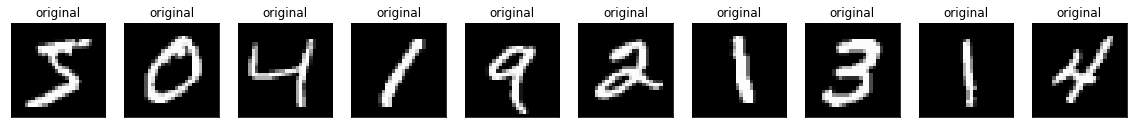

In [3]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  
  plt.imshow(x_train_ds[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

### Preprocessing

In [4]:
def preprocessing(ds, noise_level, batchsize,return_noisy=False):
  
  #change datatype from uint8 to tf.float values and normalize
  
  ds = ds.reshape((ds.shape[0], 28, 28, 1))
  ds = ds.astype('float32') / 255.
  #add dimension
  ds = tf.expand_dims(ds, -1)

  #make tuple
  target = tf.identity(ds)

  #add noise
  noisy_images = ds + noise_level * tf.random.normal(shape=ds.shape)
  noisy_images = tf.clip_by_value(noisy_images, clip_value_min=0., clip_value_max=1.)

  ds_tuple = (noisy_images, target)

  # shuffle, batch, prefetch

  ds_tuple = tf.data.Dataset.from_tensor_slices(ds_tuple).shuffle(ds.shape[0]).batch(batchsize)
  ds_tuple = ds_tuple.prefetch(tf.data.AUTOTUNE)
  if return_noisy:
    return noisy_images, ds_tuple
  else:
    return ds_tuple

In [5]:
ds_train = preprocessing(x_train_ds, 0.3, 32)
ds_test = preprocessing(x_test_ds,0.3,32)

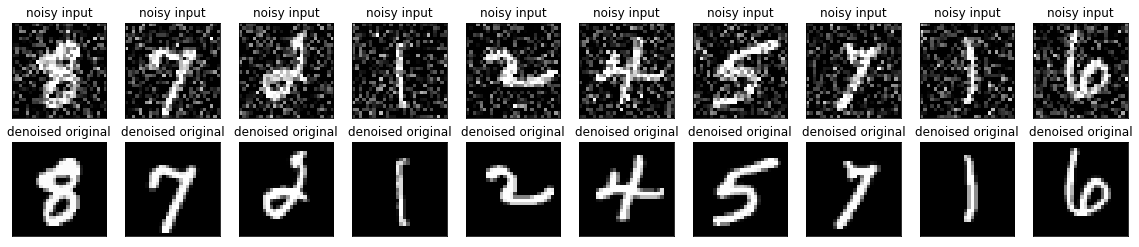

In [6]:
# visualize some images with corresponding labels
n = 10
plt.figure(figsize=(20, 4))
i=0
for input,target in ds_train:
  if i==n:
    break
  
  # display original
  ax = plt.subplot(2, n, i + 1)
  
  plt.imshow(tf.squeeze(input[i]))
  plt.title("noisy input")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(tf.squeeze(target[i]))
  plt.title("denoised original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  i += 1

plt.show()

### The Model

ConvolutionAutoencoder

In [7]:
class ConvolutionAutoencoder(Model):
  def __init__(self):
    super(ConvolutionAutoencoder, self).__init__()
    # Define Encoder with 2 Convolution Layers and 1 Dense Layer
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),
      layers.Flatten(),
      layers.Dense(10),
      ])
    
    # Define Decoder with 2 Convolution Layers and 1 Dense Layer
    self.decoder = tf.keras.Sequential([
      layers.Input(shape=(10,)),
      layers.Dense(units=7*7*32, activation=tf.nn.relu),
      tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  # Call Encoder and Decoder
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = ConvolutionAutoencoder()

In [8]:
# Compile the model and add optimizer and loss definition
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=losses.MeanSquaredError(), metrics=['accuracy'])


In [ ]:
# Encoder Summary
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense (Dense)               (None, 10)                3930      
                                                                 
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Decoder Summary
autoencoder.decoder.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1568)              17248     
                                                                 
 reshape (Reshape)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        2312      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 20,873
Trainable params: 20,873
Non-trai

### Training

In [9]:


# save logs with Tensorboard
EXPERIMENT_NAME = "autoencoder"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logging_callback = tf.keras.callbacks.TensorBoard(log_dir=f".myModel/{EXPERIMENT_NAME}/{current_time}")

epochs=10
history = autoencoder.fit(ds_train,
                epochs=epochs,
                shuffle=True,
                validation_data=ds_test)

Epoch 1/10
1875/1875 [==============================] - 17s 5ms/step - loss: 0.0403 - accuracy: 0.8063 - val_loss: 0.0227 - val_accuracy: 0.8064
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0217 - accuracy: 0.8082 - val_loss: 0.0202 - val_accuracy: 0.8079
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0199 - accuracy: 0.8092 - val_loss: 0.0192 - val_accuracy: 0.8094
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0191 - accuracy: 0.8097 - val_loss: 0.0186 - val_accuracy: 0.8087
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0185 - accuracy: 0.8100 - val_loss: 0.0181 - val_accuracy: 0.8095
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0181 - accuracy: 0.8103 - val_loss: 0.0177 - val_accuracy: 0.8091
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0178 - accuracy: 0.8104 - val_loss: 0.0175 - val_accurac

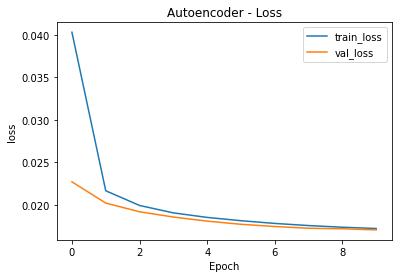

In [10]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
#plt.plot(history.history["MAE"])
#plt.plot(history.history["val_MAE"])
plt.legend(labels=["train_loss","val_loss", "train_acc", "val_acc"])
plt.title('Autoencoder - Loss')
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.savefig(f"testing: e={epochs}")
plt.show()

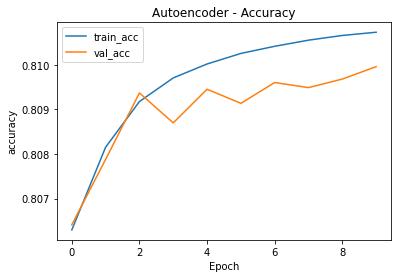

In [11]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(labels=["train_acc", "val_acc"])
plt.title('Autoencoder - Accuracy')
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.savefig(f"testing: e={epochs}")
plt.show()

##### Visualize Results on test data

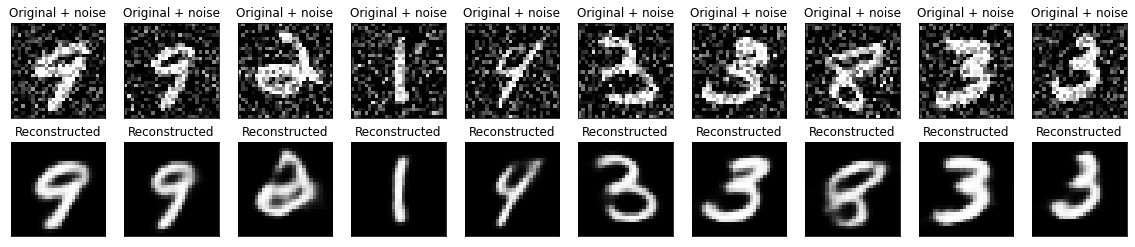

In [12]:
# visualize some Test Images with our AutoEncoder
n = 10
plt.figure(figsize=(20, 4))
i=0

# select images from ds_test
for input,_ in ds_test:
  if i==n: # only n images
    break
  # apply autoencoder to encode and then decode images
  encoded_img = autoencoder.encoder(input).numpy()
  decoded_img = autoencoder.decoder(encoded_img).numpy()
  
  # display Noisy Image that is input to Model
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(tf.squeeze(input[i]))
  plt.title("Original + noise")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(tf.squeeze(decoded_img[i]))
  plt.title("Reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  i += 1

plt.show()

# Latent Space Analysis

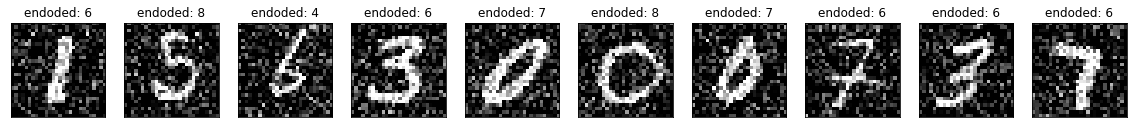

In [13]:
# visualize some images with corresponding labels
n = 10
plt.figure(figsize=(20, 4))
i=0

for input,_ in ds_test:
  encoded_img = autoencoder.encoder(input).numpy()
  t = np.argmax(encoded_img, axis=1)
  decoded_img = autoencoder.decoder(encoded_img).numpy()
# for input,target in ds_train:
  if i==n:
    break
  
  # display original
  ax = plt.subplot(2, n, i + 1)
  
  plt.imshow(tf.squeeze(input[i]))
  plt.title(f'endoded: {t[i]}')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  i += 1
plt.show()

In [14]:
noisy, ds_train_1000 = preprocessing(x_train_ds_1000, 0.3, 32,True)
noisy = tf.reshape(noisy, [1000, 784]) #[rows, columns]
noisy.shape

TensorShape([1000, 784])

In [15]:
all_t = list()
for input,_ in ds_train_1000:
  encoded_img = autoencoder.encoder(input).numpy()
  t = np.argmax(encoded_img, axis=1)
  all_t.append(t.tolist())
all_t = [item for sublist in all_t for item in sublist]

embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(noisy)

In [16]:
# create dataframe
value1 = list()
value2 = list()
for i in range(len(embedded)):
  value1.append(embedded[i][0])
  value2.append(embedded[i][1])
embed_df = pd.DataFrame({'value1':value1, 'value2': value2, 'target': all_t})

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


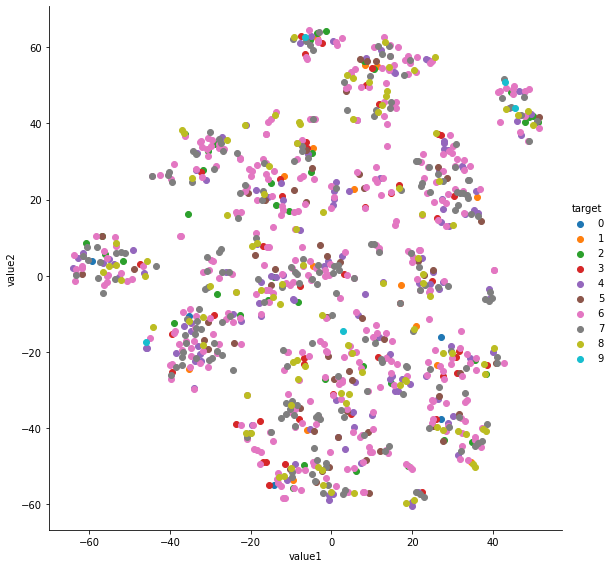

In [17]:
grid = sns.FacetGrid(embed_df, size=8, hue='target')
grid.map(plt.scatter, 'value1', 'value2').add_legend()

 - We are not seeing it more densed because we have less examples

## 2.5 Variational AutoEncoder

In [18]:
# import libraries
from IPython import display
import  PIL, time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


In [19]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    # get Latent Dimension
    self.latent_dim = latent_dim

    # Define Encoder with 2 convolution layers and 1 Dense layer of Latent Dimensions
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    # Define Decoder with 1 Dense Layer and 2 Convolution layers
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  # Generate a Sample for the decoder for training, based on the latent distribution with reparameterization so backpropogate gradients properly
  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  # TO Execute Encoder
  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  # Reparameterize the encoder output
  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  # Execute Decoder Function
  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

# Define the Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Calculate log likelyhood for loss function
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

# Define Loss Funtion ( Monte Carlo estimate)
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.expand_dims(tf.squeeze(x_logit),axis=-1), labels=tf.expand_dims(tf.squeeze(x),axis=-1))
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.
 
  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  Start by iterating over the dataset
  During each iteration, pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior 
  then apply the reparameterization trick to sample from 
  Finally, pass the reparameterized samples to the decoder to obtain the logits of the generative distribution 
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

In [20]:
def generate_images(model, epoch, test_sample,target_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(20, 400))
  for i in range(test_sample.shape[0]):
    plt.subplot(1, 10, i + 1)
    plt.imshow(tf.squeeze(test_sample[i, :, :, 0]), cmap='gray')
    plt.axis('off')
    plt.title("Original + noise")

  fig = plt.figure(figsize=(20, 400))
  for i in range(predictions.shape[0]):
    plt.subplot(1, 10, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.title("VAE output")
  
  fig = plt.figure(figsize=(20, 400))
  for i in range(target_sample.shape[0]):
    plt.subplot(1, 10, i + 1)
    plt.imshow(tf.squeeze(target_sample[i, :, :, 0]), cmap='gray')
    plt.axis('off')
    plt.title("Original")

  plt.show()

In [21]:
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 10
num_examples_to_generate = 10

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)
# Pick a sample of the test set for generating output images
batchsize = 32
assert batchsize >= num_examples_to_generate
for test_batch,target_batch in ds_test:
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]
  target_sample = target_batch[0:num_examples_to_generate, :, :, :]


Epoch: 10,Train loss 336.34063720703125 Test set ELBO: 340.45196533203125, time elapse for current epoch: 5.545653820037842


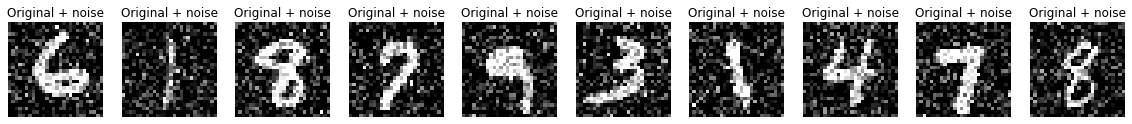

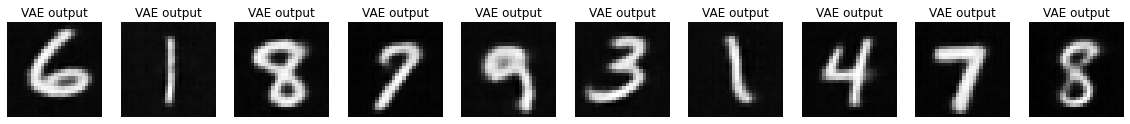

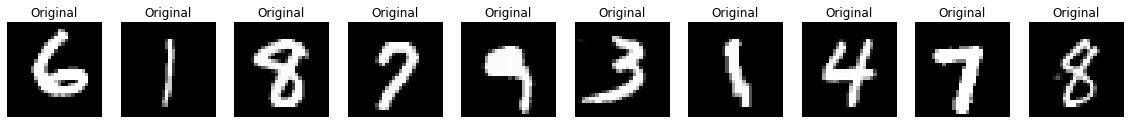

In [22]:
epochs = 10
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x,_ in ds_train:
    train_loss = train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x,_ in ds_test:
    loss(compute_loss(model, test_x))
  elbo = loss.result()
  display.clear_output(wait=False) 
  print(f'Epoch: {epoch},Train loss {train_loss} Test set ELBO: {elbo}, time elapse for current epoch: {end_time - start_time}')
  generate_images(model, epoch, test_sample,target_sample)